# Lab2

## Užduotis

Antroje užduotyje reikia realizuoti vaizdų klasifikavimo modelį.
Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pademonstruoti, kaip jūsų realizuotas modelis veikia.
Atsiskaitymo metu, turėsite gebėti papasakoti, kaip realizuotas, jūsų modelis.
Programinės įrangos sprendimą galite naudoti savo nuožiūra.

- [ ] Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3.
- [ ] Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes.
- [ ] Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. *confusion matrix*), tikslumas, precizija, atkūrimas ir F1.

Duomenų klasėms parinktos iš [OpenImages V6](https://storage.googleapis.com/openimages/web/index.html) objektų aptikimo uždavinio duomenų rinkinio.

## Įgyvendintų papildomų funkcijų papildomi balai $P_2$ pasirinktinai:

- [ ] Palyginimas palyginant aukšto lygio požymius (angl. _similiarity search_)
- [ ] Sukuriant vartotojo sąsają ir modelio iškvietimą per REST API.

### Duomenų atsiuntimas

```{bash}
brew install awscli
```

```{bash}
pipx install oidv6
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data train --no-labels --limit 500 --dest_dir lab2/OIDv6/train
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data test --no-labels --limit 100 --dest_dir lab2/OIDv6/test
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data validation --no-labels --limit 100 --dest_dir lab2/OIDv6/validation
```

In [1]:
from pathlib import Path
from typing import Callable
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.optim as optim
from importlib import reload
from copy import deepcopy
from torchvision.transforms import transforms as trans
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Device
import torch

device: torch.device = torch.device('cpu')

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("WARN: Neither MPS nor CUDA device was found.")


In [3]:
DIM = 32
NUM_CHANNELS = 3
NUM_CLASSES = 4

class Net(nn.Module):
	def __init__(self, num_classes=3):
		super(Net, self).__init__()
		self.softmax = nn.Softmax()

		self.conv1 = nn.Conv2d(in_channels=NUM_CHANNELS, out_channels=32, kernel_size=3, padding=1)
		self.batchnorm1 = nn.BatchNorm2d(32)
		self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
		self.batchnorm2 = nn.BatchNorm2d(32)
		self.maxpool1 = nn.MaxPool2d(kernel_size=2)
		self.dropout1 = nn.Dropout2d(p=0.2)

		self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
		self.batchnorm3 = nn.BatchNorm2d(64)
		self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
		self.batchnorm4 = nn.BatchNorm2d(64)
		self.maxpool2 = nn.MaxPool2d(kernel_size=2)
		self.dropout2 = nn.Dropout2d(p=0.3)

		self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
		self.batchnorm5 = nn.BatchNorm2d(128)
		self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
		self.batchnorm6 = nn.BatchNorm2d(128)
		self.maxpool3 = nn.MaxPool2d(kernel_size=2)
		self.dropout3 = nn.Dropout2d(p=0.4)

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(128 * (DIM // 8) * (DIM // 8), 128)
		self.batchnorm_fc = nn.BatchNorm1d(128)
		self.dropout_fc = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(128, num_classes)

	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = self.batchnorm1(x)
		x = torch.relu(self.conv2(x))
		x = self.batchnorm2(x)
		x = self.maxpool1(x)
		x = self.dropout1(x)

		x = torch.relu(self.conv3(x))
		x = self.batchnorm3(x)
		x = torch.relu(self.conv4(x))
		x = self.batchnorm4(x)
		x = self.maxpool2(x)
		x = self.dropout2(x)

		x = torch.relu(self.conv5(x))
		x = self.batchnorm5(x)
		x = torch.relu(self.conv6(x))
		x = self.batchnorm6(x)
		x = self.maxpool3(x)
		x = self.dropout3(x)

		x = self.flatten(x)
		x = torch.relu(self.fc1(x))
		x = self.batchnorm_fc(x)
		x = self.dropout_fc(x)
		x = self.fc2(x)

		return x

In [4]:
model = Net(num_classes = NUM_CLASSES).to(device)

In [5]:
train_trans = trans.Compose([
  trans.RandomHorizontalFlip(),
  trans.RandomRotation(20),
  trans.ColorJitter(brightness = 0.4, contrast = 0.2, saturation = 0.2, hue=0.1),
  trans.RandomGrayscale(p=0.1),
  trans.RandomResizedCrop(size = (32, 32), scale = (0.75, 0.75)),
  trans.ToTensor(),
  trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

validation_trans = trans.Compose([
  trans.Resize((32, 32)),
  trans.ToTensor(),
  trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_trans = validation_trans


In [6]:
train_ds      = ImageFolder("lab2/OIDv6/train",      transform = train_trans)
validation_ds = ImageFolder("lab2/OIDv6/validation", transform = validation_trans)
test_ds       = ImageFolder("lab2/OIDv6/test",       transform = test_trans)

In [7]:
BATCH_SIZE = 128
train_dl      = DataLoader(train_ds,      shuffle = True,  batch_size = BATCH_SIZE, num_workers = 8)
validation_dl = DataLoader(validation_ds, shuffle = False, batch_size = BATCH_SIZE, num_workers = 8)
test_dl       = DataLoader(test_ds,       shuffle = False, batch_size = BATCH_SIZE, num_workers = 8)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


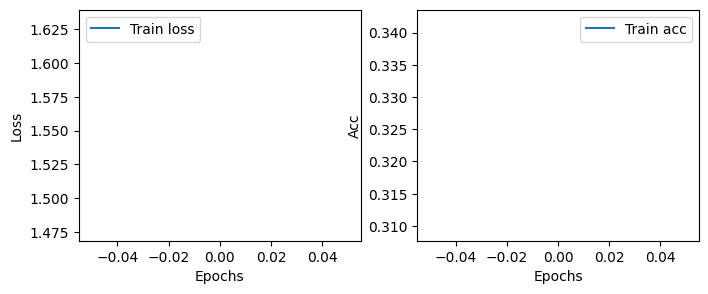

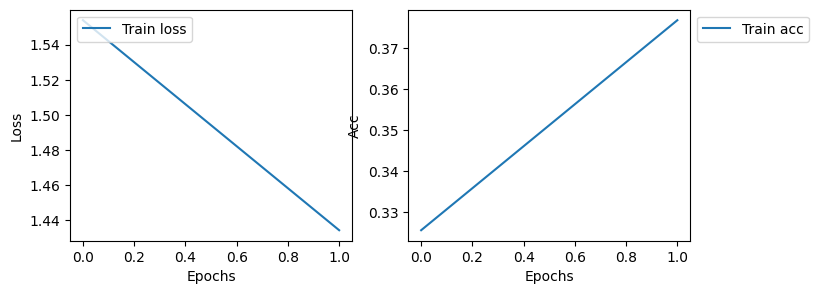

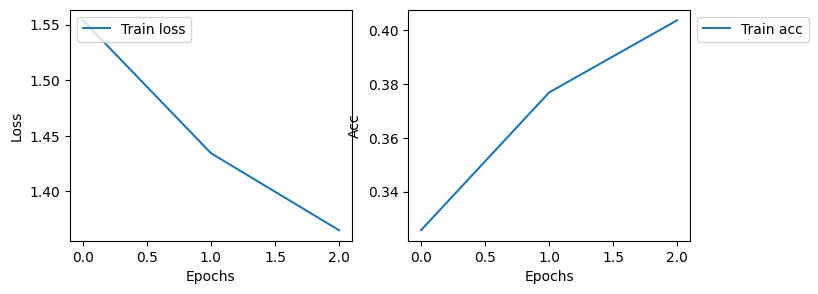

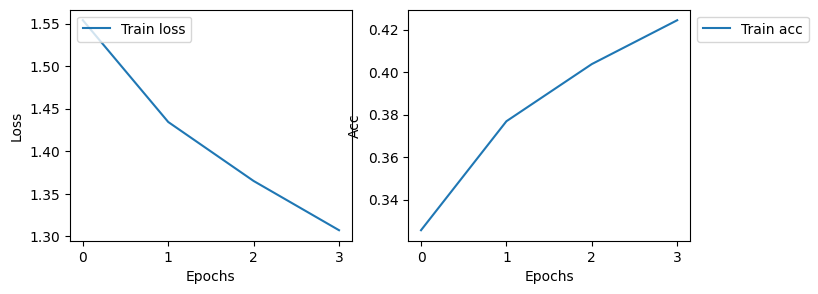

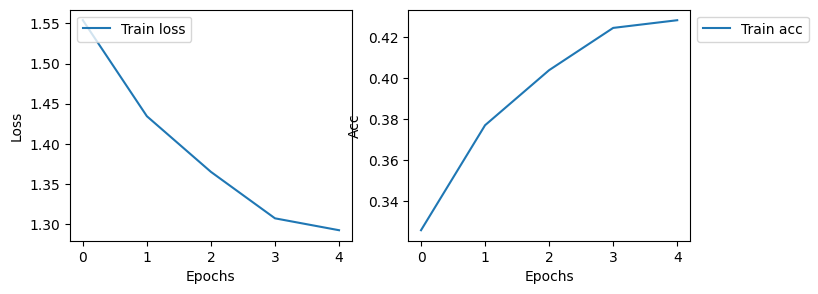

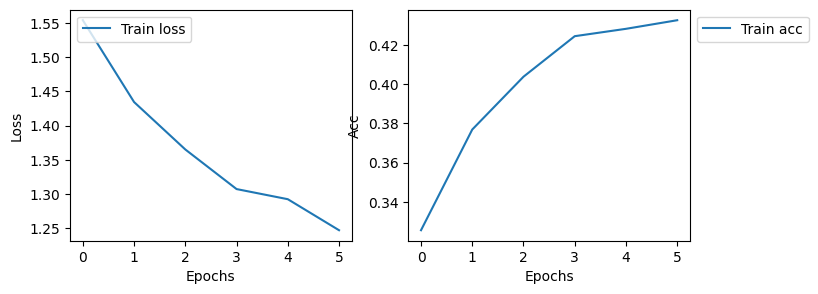

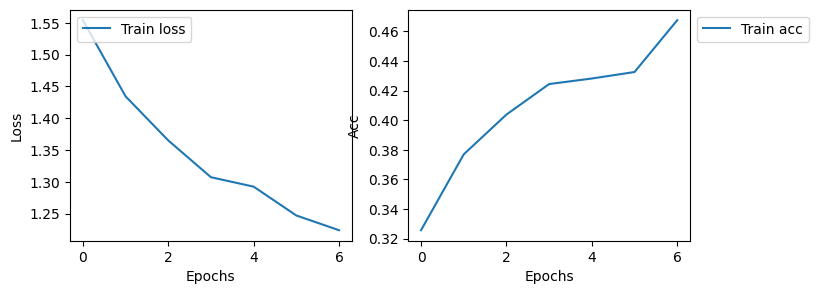

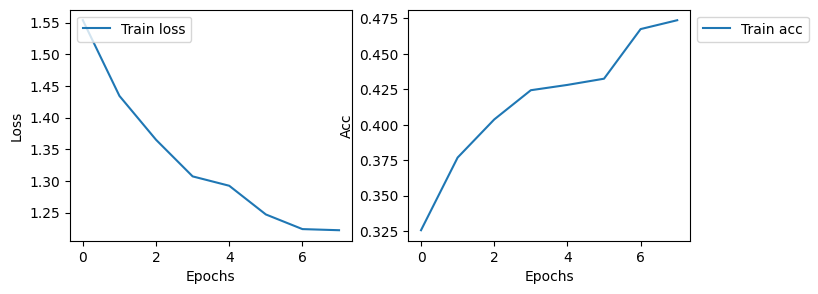

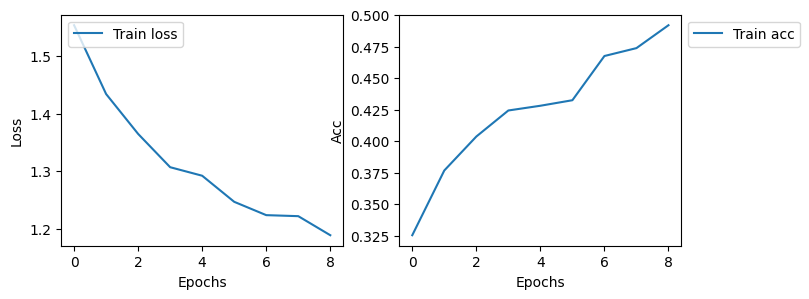

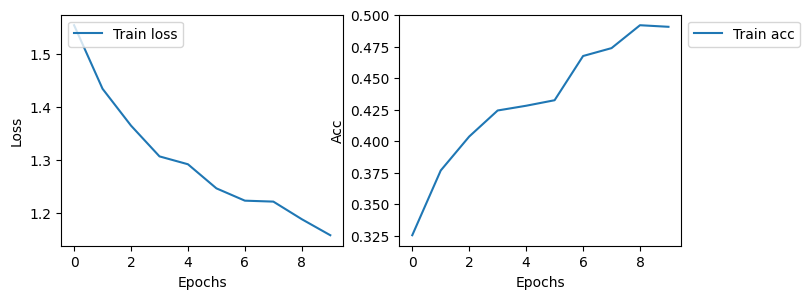

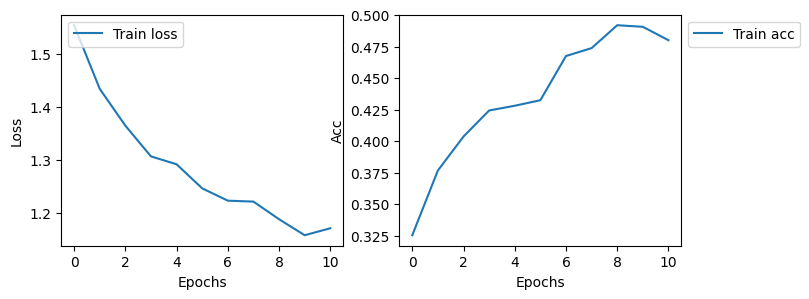

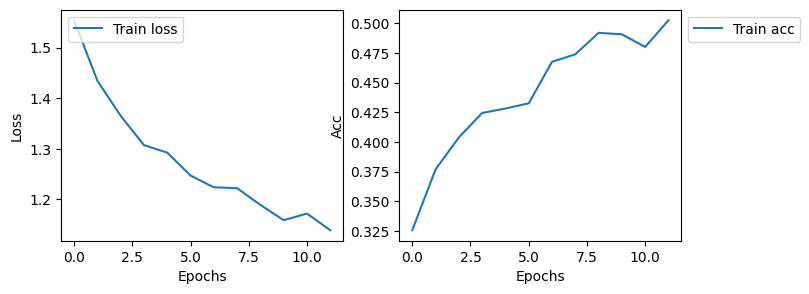

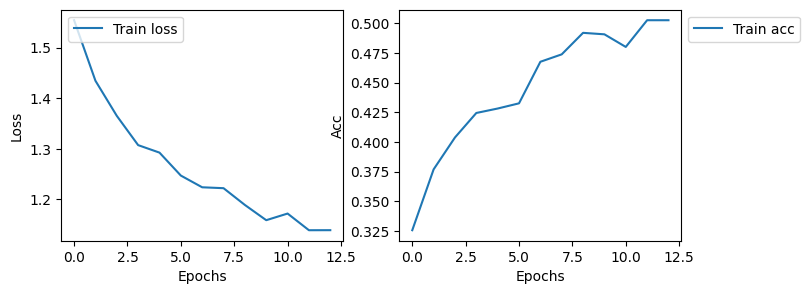

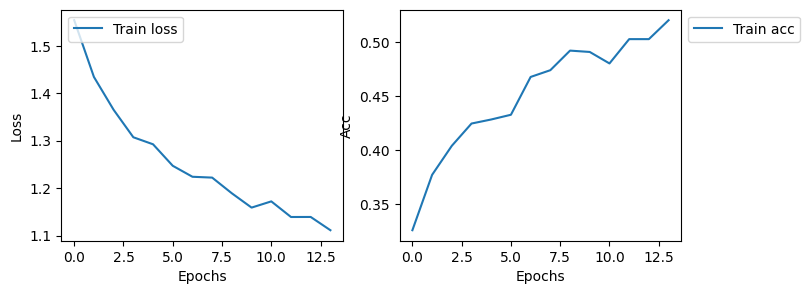

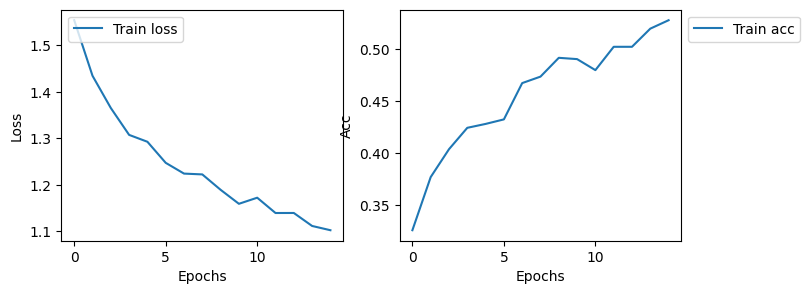

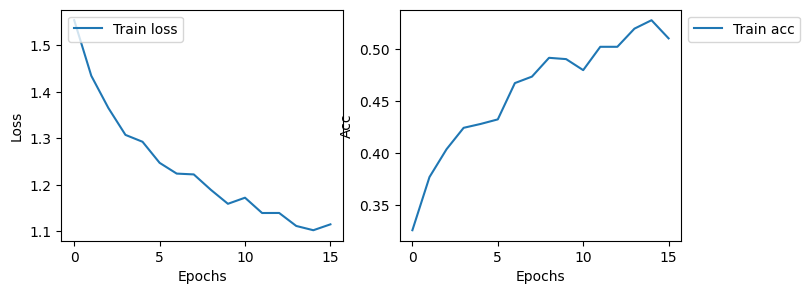

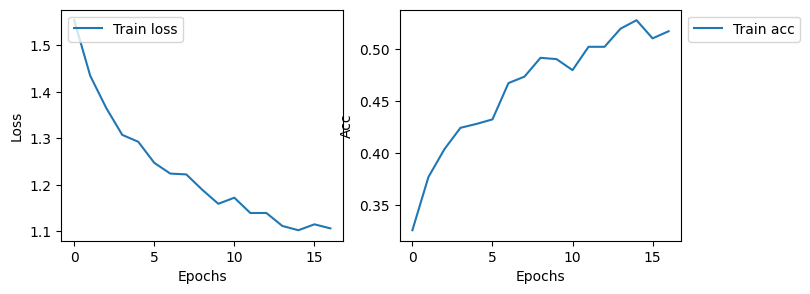

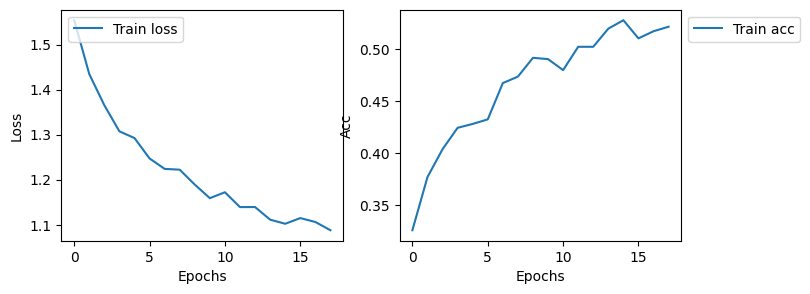

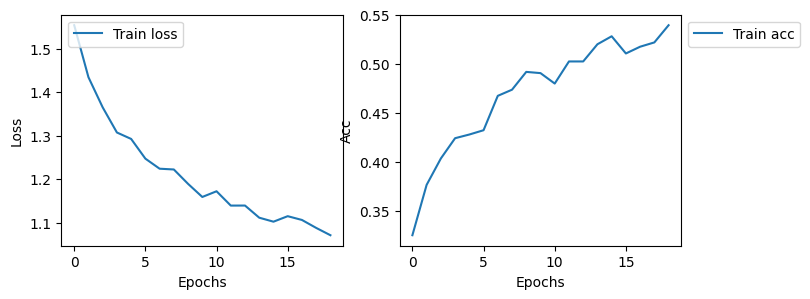

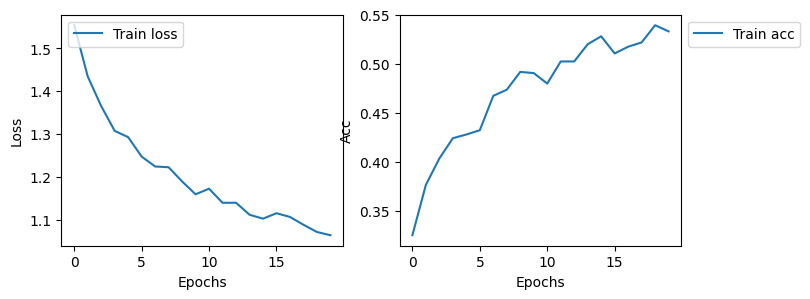

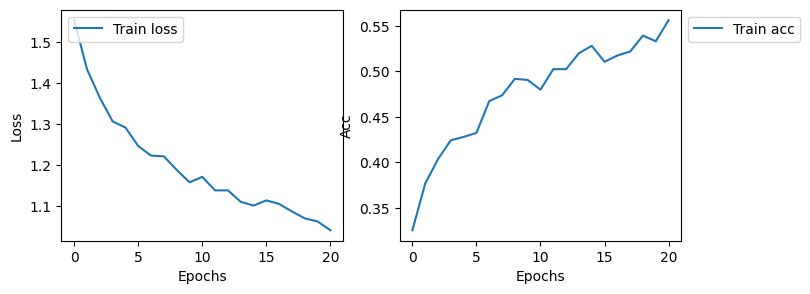

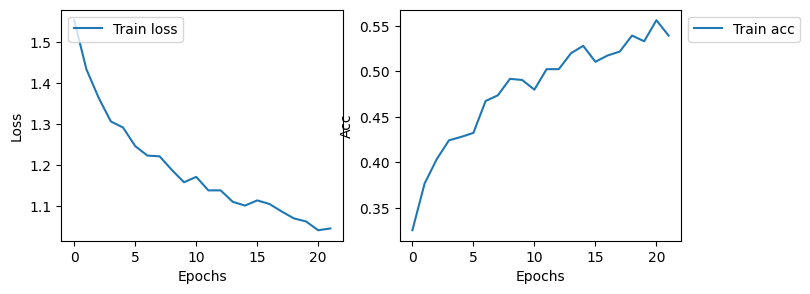

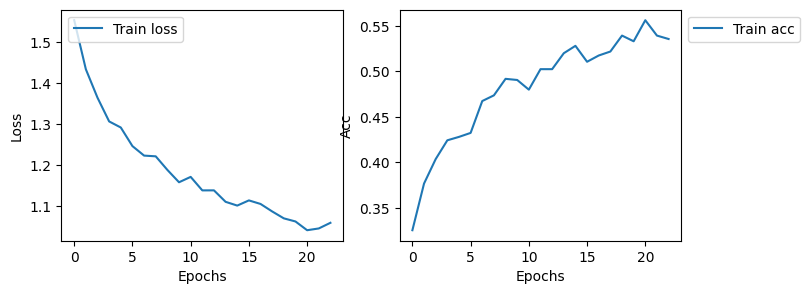

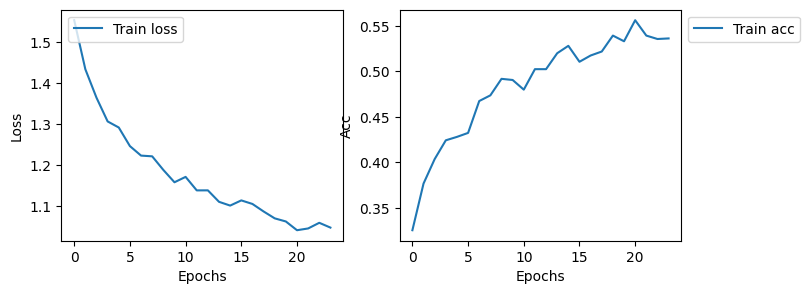

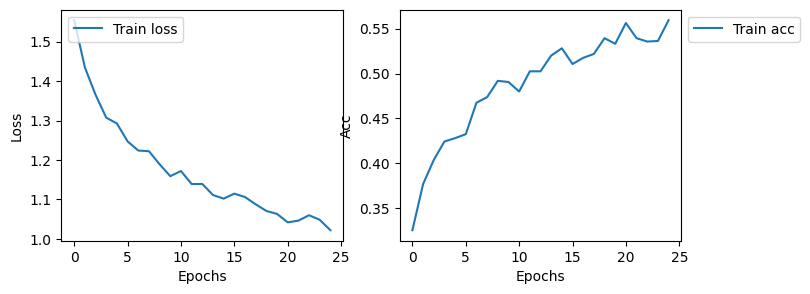

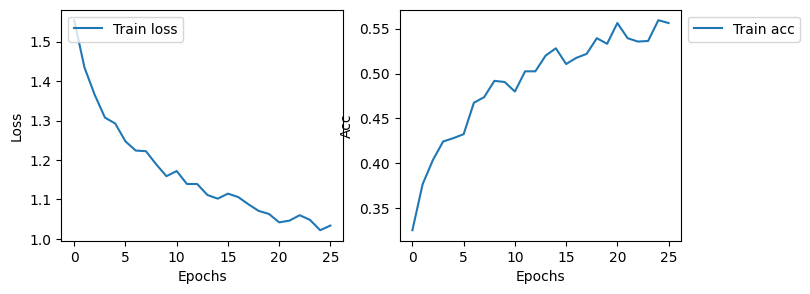

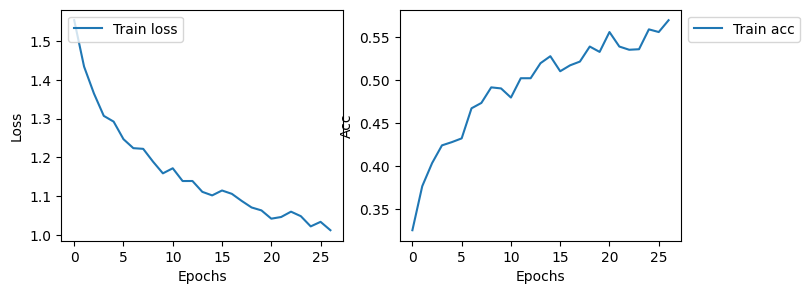

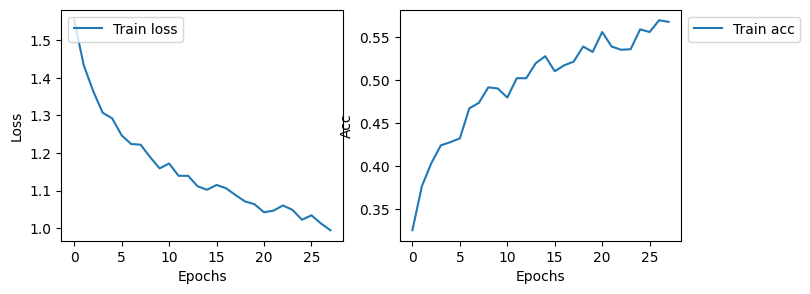

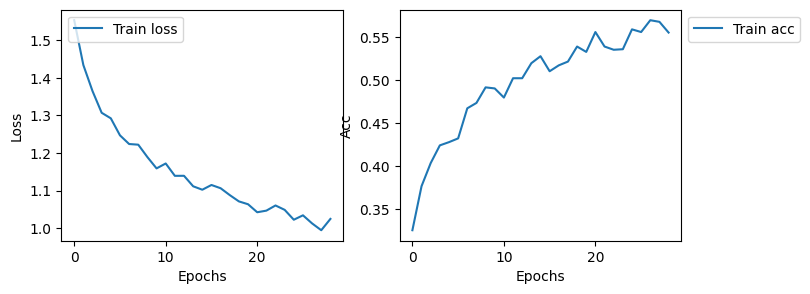

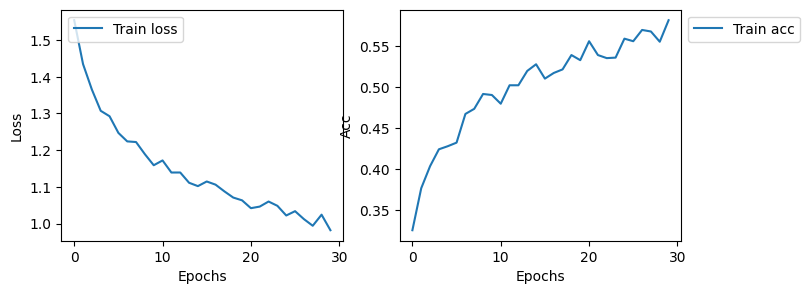

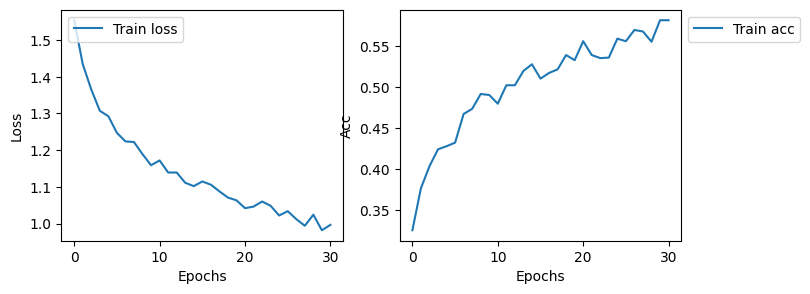

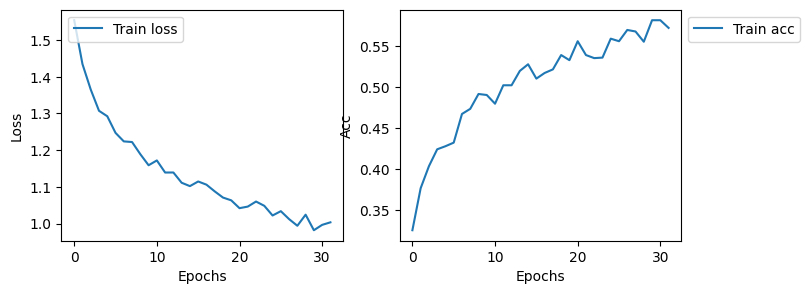

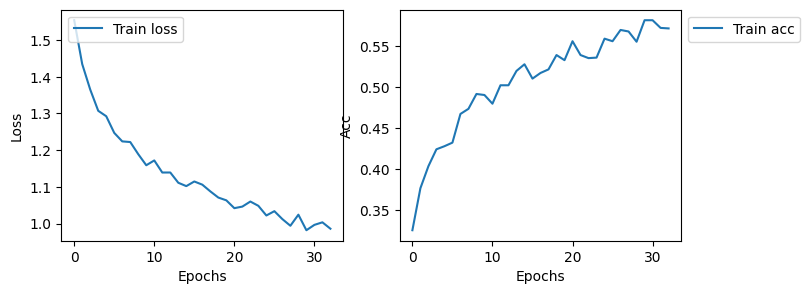

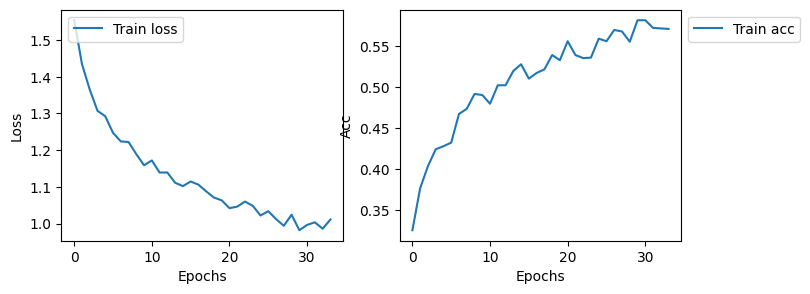

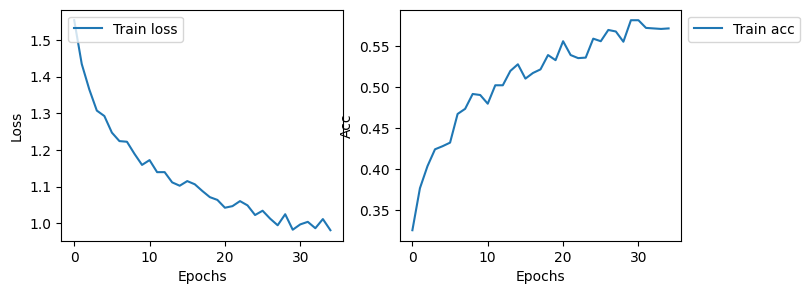

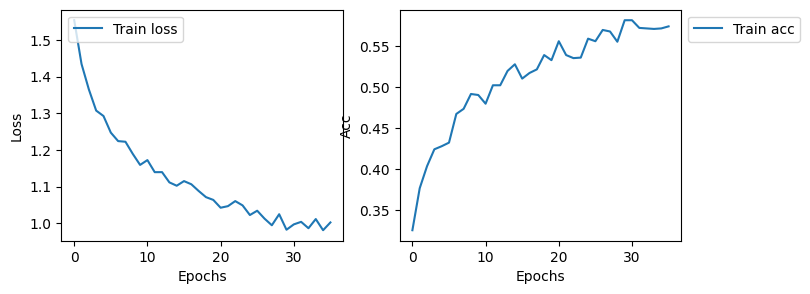

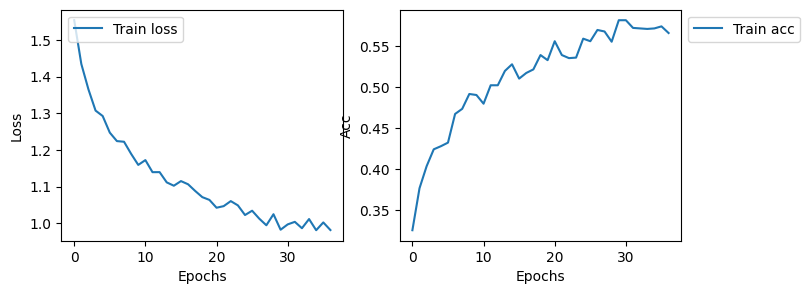

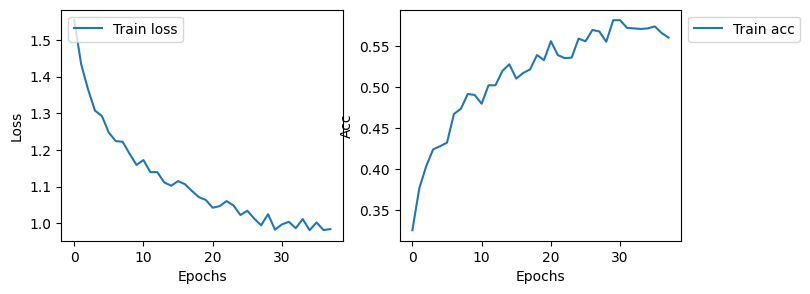

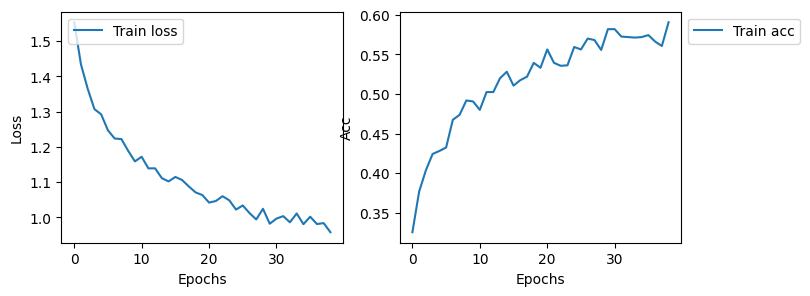

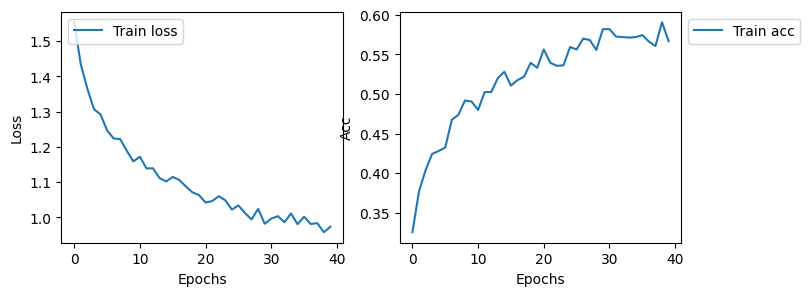

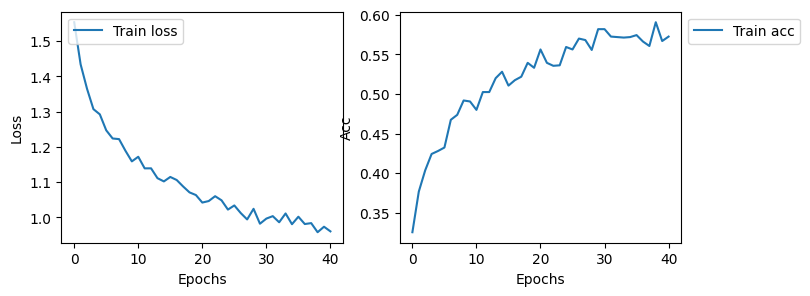

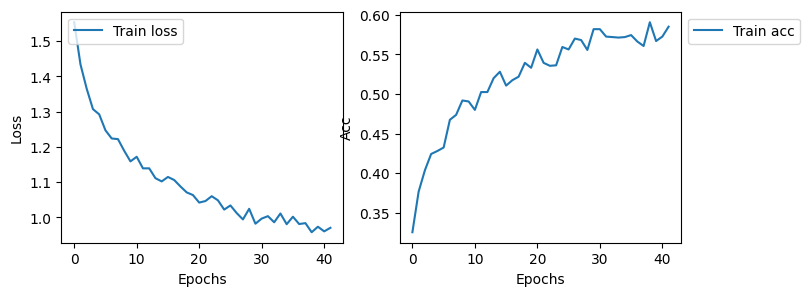

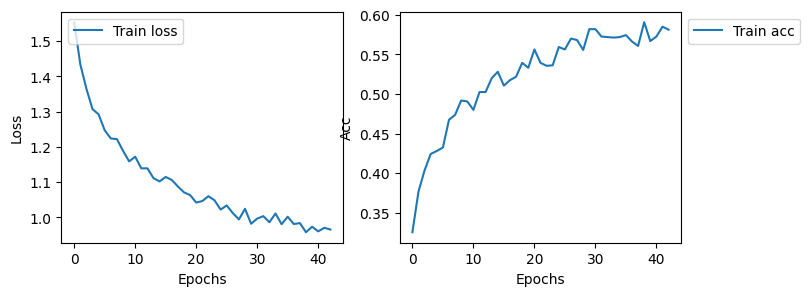

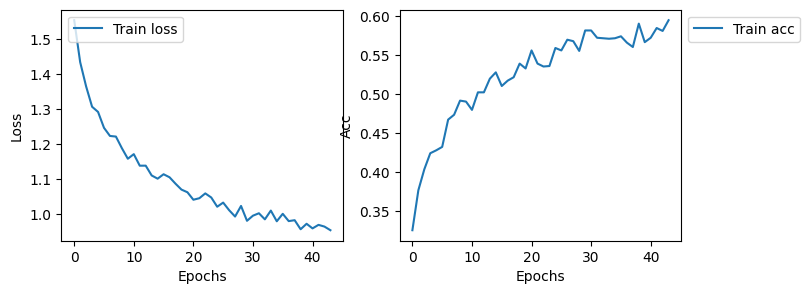

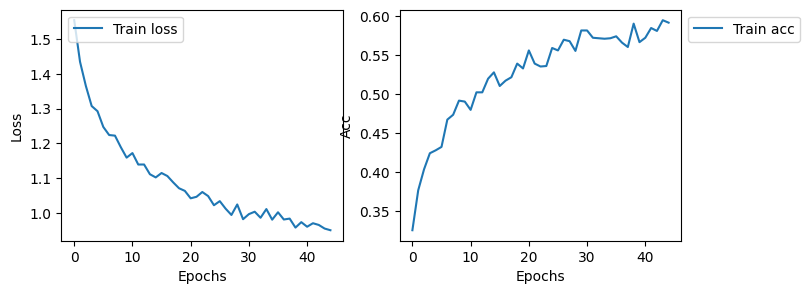

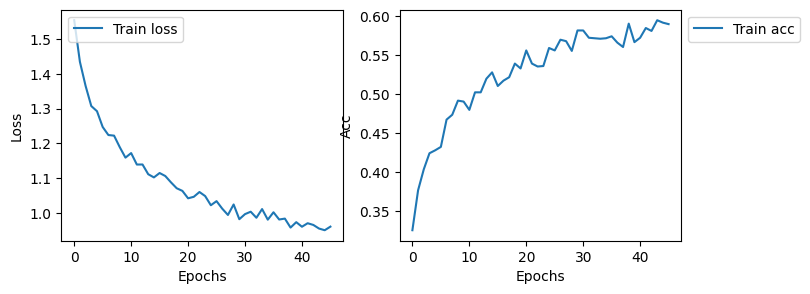

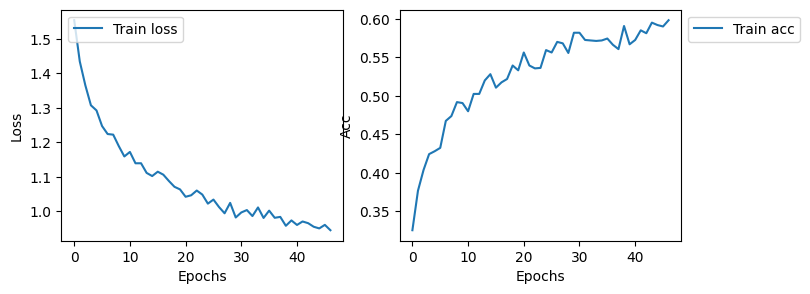

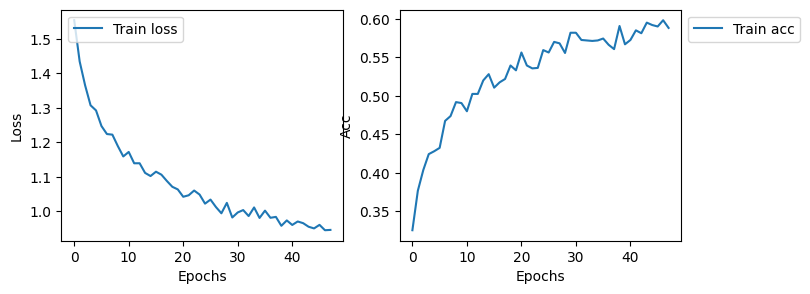

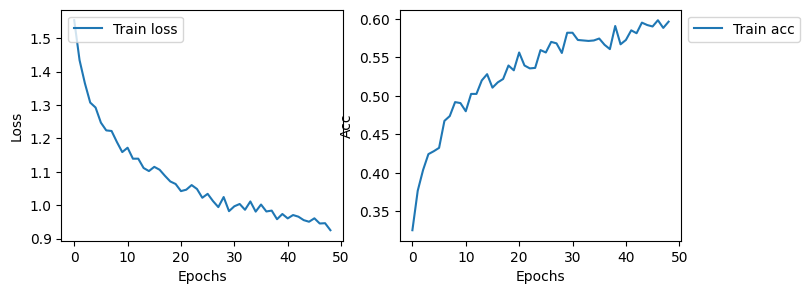

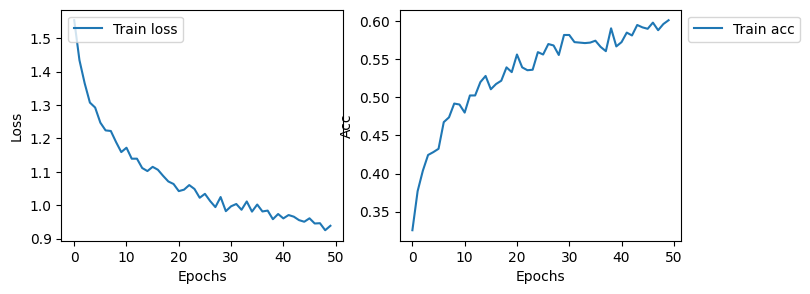

In [9]:
from torch import cat as c
from torch import tensor as t

import lab2.graphs
reload(lab2.graphs)
from lab2.graphs import display_loss, display_acc

train_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0, 0)
}; th = train_history

validation_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0, 0)
}; vh = validation_history

NUM_EPOCHS = 50
VALIDATE = False

softmax = nn.Softmax()

for epoch in range(NUM_EPOCHS):
  model.train()

  l = t([])
  y = t([])
  y_hat = t([])
  ix = -1
  for inputs, labels in train_dl:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    y =     c((y, labels.detach().cpu().to("cpu")), dim = -1)
    y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)
    l = c((l, loss.cpu().detach().to("cpu").reshape(1)))

    if ix == 0:
      break
    ix -= 1

  # print(f"  l_shape {l.shape}")
  # print(f"  y_shape {y.shape}")
  # print(f"  ys_shape {th['ys'].shape}")
  
  th['ls'] = c((th['ls'], torch.mean(l).unsqueeze(0)))
  th['ys'] = c((th['ys'].reshape(-1, y.shape[0]), y.unsqueeze(0)))
  th['y_hats'] = c((th['y_hats'].reshape(-1, y.shape[0]), y_hat.unsqueeze(0)))

  if VALIDATE:
    l = t([])
    y = t([])
    y_hat = t([])
    model.eval()
    with torch.no_grad():
      for inputs, labels in validation_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        y =     c((y, labels.detach().cpu().to("cpu")), dim = -1)
        y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)
        l = c((l, loss.cpu().detach().to("cpu").reshape(1)))
  
    vh['ls']     = c((vh['ls'], torch.mean(l).unsqueeze(0)))
    vh['ys']     = c((vh['ys'].reshape(-1, y.shape[0]), y.unsqueeze(0)))
    vh['y_hats'] = c((vh['y_hats'].reshape(-1, y.shape[0]), y_hat.unsqueeze(0)))

  plt.close()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (8, 3))
  display_loss(ax1, train_history, label = 'Train loss')
  display_acc(ax2, train_history, label = 'Train acc')

  if VALIDATE:
    display_loss(ax1, validation_history, label = 'Validation loss')
    display_acc(ax2, validation_history, label = 'Validation acc')

  plt.pause(0.1)


In [10]:
test_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0,0)
}; test_history


y = t([])
y_hat = t([])
model.eval()
with torch.no_grad():
  for inputs, labels in test_dl:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    y     = c((y, labels.detach().cpu().to("cpu")), dim = -1)
    y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)


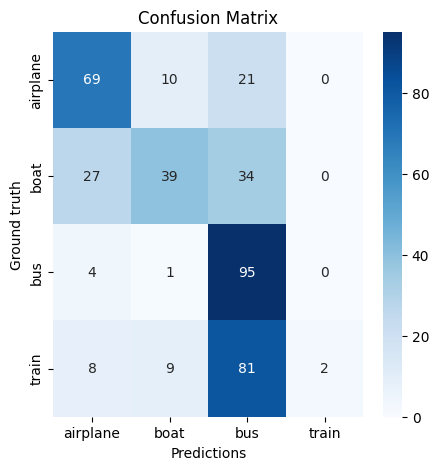

              precision    recall  f1-score   support

    airplane       0.64      0.69      0.66       100
        boat       0.66      0.39      0.49       100
         bus       0.41      0.95      0.57       100
       train       1.00      0.02      0.04       100

    accuracy                           0.51       400
   macro avg       0.68      0.51      0.44       400
weighted avg       0.68      0.51      0.44       400



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

conf_matrix = confusion_matrix(y, y_hat)
class_names = test_ds.classes

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predictions')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y, y_hat, target_names=class_names))
